In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import plotly.express as px
from plottable import ColumnDefinition, Table

import seaborn as sns
import numpy as np

import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import multilabel_confusion_matrix, f1_score, accuracy_score
import time

# Multiple Linear Regression
import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS, summarize, poly)
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

import random
random.seed(34)

In [80]:
data = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv", index_col="Person ID")
# data.info()

# 1. Introduction

Data to the project have been downloaded from the kaggle website: https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset. \
The objective is to predict *Quality of Sleep*. It is beneficial to be able to identify the factors that contribute to a good night's sleep, as this enables us to take appropriate measures to ensure we get the requisite amount of rest. \
The study will employ a variety of well-established machine learning techniques, including PCA, SVM and Random Forest. Furthermore, the implementation of statistical methodologies will be undertaken. Primarily, linear regression will be utilised for the purpose of prediction, and secondly for the purpose of comparison with other methods.

# 2. Dataset

| Column                             | Data Type      | Description                                                                 |
|------------------------------------|----------------|-----------------------------------------------------------------------------|
| Gender                             | Object         | The gender of the person (Male/Female).                                    |
| Age                                | Int64          | The age of the person in years.                                            |
| Occupation                         | Object         | The occupation or profession of the person.                                |
| Sleep Duration (hours)             | Float64        | The number of hours the person sleeps per day.                             |
| Quality of Sleep (scale: 1-10)     | Int64          | A subjective rating of the quality of sleep, ranging from 1 to 10.         |
| Physical Activity Level (minutes/day) | Int64       | The number of minutes the person engages in physical activity daily.       |
| Stress Level (scale: 1-10)         | Int64          | A subjective rating of the stress level experienced by the person, from 1 to 10. |
| BMI Category                       | Object         | The BMI category of the person (e.g., Underweight, Normal, Overweight).    |
| Blood Pressure (systolic/diastolic)| Object         | The blood pressure measurement, indicated as systolic over diastolic pressure. |
| Heart Rate (bpm)                   | Int64          | The resting heart rate of the person in beats per minute.                  |
| Daily Steps                        | Int64          | The number of steps the person takes per day.                              |
| Sleep Disorder                     | Object         | The presence or absence of a sleep disorder (None, Insomnia, Sleep Apnea). |

\
The dateset contains 12 columns and 374 columns. The initial five rows are printed below. It can be observed that the column designated *Sleep Disorder* contains NaN values. However, upon printing the unique values for this column, it can be concluded that the individual in question does not suffer from a sleep disorder. The remaining columns do not exhibit any instances of missing data. The second issue is the presentation of the blood pressure data, which is currently presented in a single column and has the data type object. It would be more appropriate to split this data into two columns, one for systolic and one for diastolic blood pressure, with the data types integer for both.


In [81]:
data.sample(7)
# data['Sleep Disorder'].unique()
# data['BMI Category'].unique()
data.describe()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


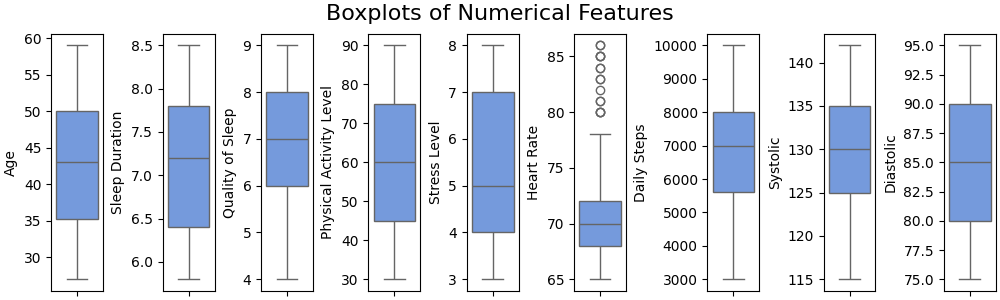

In [86]:
data[['Systolic', 'Diastolic']] = data['Blood Pressure'].str.split('/', expand=True)
data['Systolic'] = data['Systolic'].astype(int)
data['Diastolic'] = data['Diastolic'].astype(int)
data['BMI Category'] = data['BMI Category'].replace('Normal Weight', 'Normal')
data['Sleep Disorder'] = data['Sleep Disorder'].fillna('None')

fig, axes = plt.subplots(1, 9, figsize=(10, 3), constrained_layout=True)

# Loop through numerical features and create box plots
for i, feature in enumerate(data.select_dtypes(include=['number']).columns):
    ax = axes[i]
    sns.boxplot(y=data[feature], ax=ax, color='cornflowerblue')
    ax.set_ylabel(feature, fontsize=10)

# Add a common title for box plots
plt.suptitle('Boxplots of Numerical Features', fontsize=16)
plt.show()


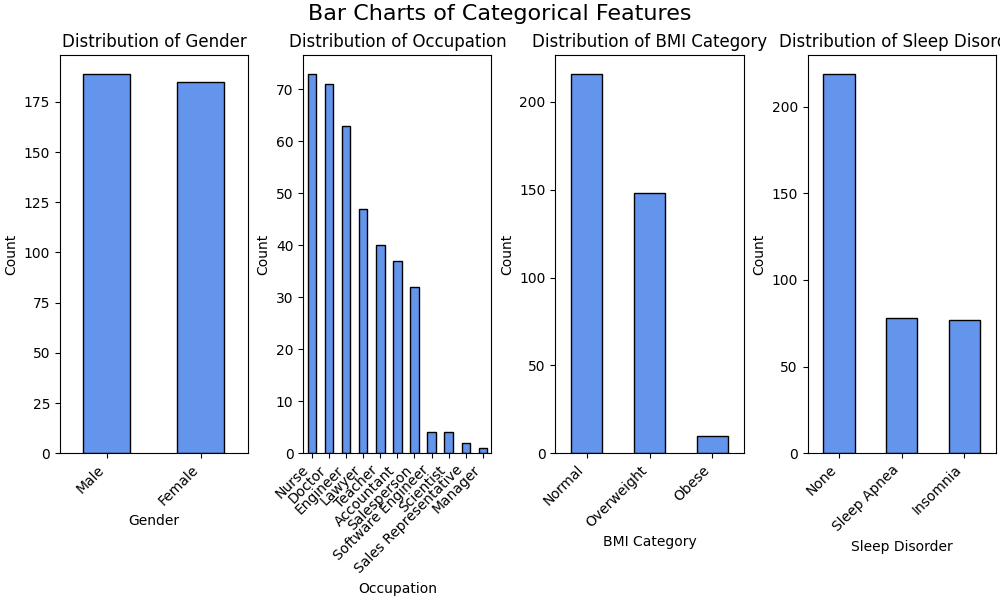

In [89]:
# bar charts for categorical features
categorical_features = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']

# figure for bar plots
fig, axes = plt.subplots(1, len(categorical_features), figsize=(10, 6), constrained_layout=True)

# Loop through categorical features and create bar plots
for i, categorical_feature in enumerate(categorical_features):
    ax = axes[i] if len(categorical_features) > 1 else axes  # Handle single plot case
    counts = data[categorical_feature].value_counts()
    counts.plot(kind='bar', ax=ax, color='cornflowerblue', edgecolor='black')
    ax.set_title(f'Distribution of {categorical_feature}', fontsize=12)
    ax.set_xlabel(categorical_feature, fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.set_xticklabels(counts.index, rotation=45, ha='right')

# Add a common title for bar plots
plt.suptitle('Bar Charts of Categorical Features', fontsize=16)
plt.show()


The data set includes working individuals across a range of age groups, with a minimum age of 27 and a maximum age of 59. The majority of the subjects reported having good quality sleep. The prevalence of individuals reporting a quality of sleep equal to or greater than 6 is 75%. Furthermore, 25% of the respondents indicated a quality of sleep equal to or greater than 8. In contrast, the distribution of values in the 'Stress level' category is more uniform, with a median score of 5. High level of stress is understandable, because most of responders are nurse and doctors, who have a high level of responsibility in their roles. The majority of the current population leads a healthy lifestyle, with the vast majority engaging in at least 30 minutes of physical activity on a daily basis and half of them exceeding the recommended 7,000 steps per day. Furthermore, the data concerning heart rate and blood pressure are also representative of a positive outcome. Nevertheless, nearly half of the respondents reported some form of sleep disorder. \
Prior to the construction of a model, an investigation into the correlation matrix will also be conducted.

In [6]:
data.columns

Index(['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep',
       'Physical Activity Level', 'Stress Level', 'BMI Category',
       'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder',
       'Systolic', 'Diastolic'],
      dtype='object')

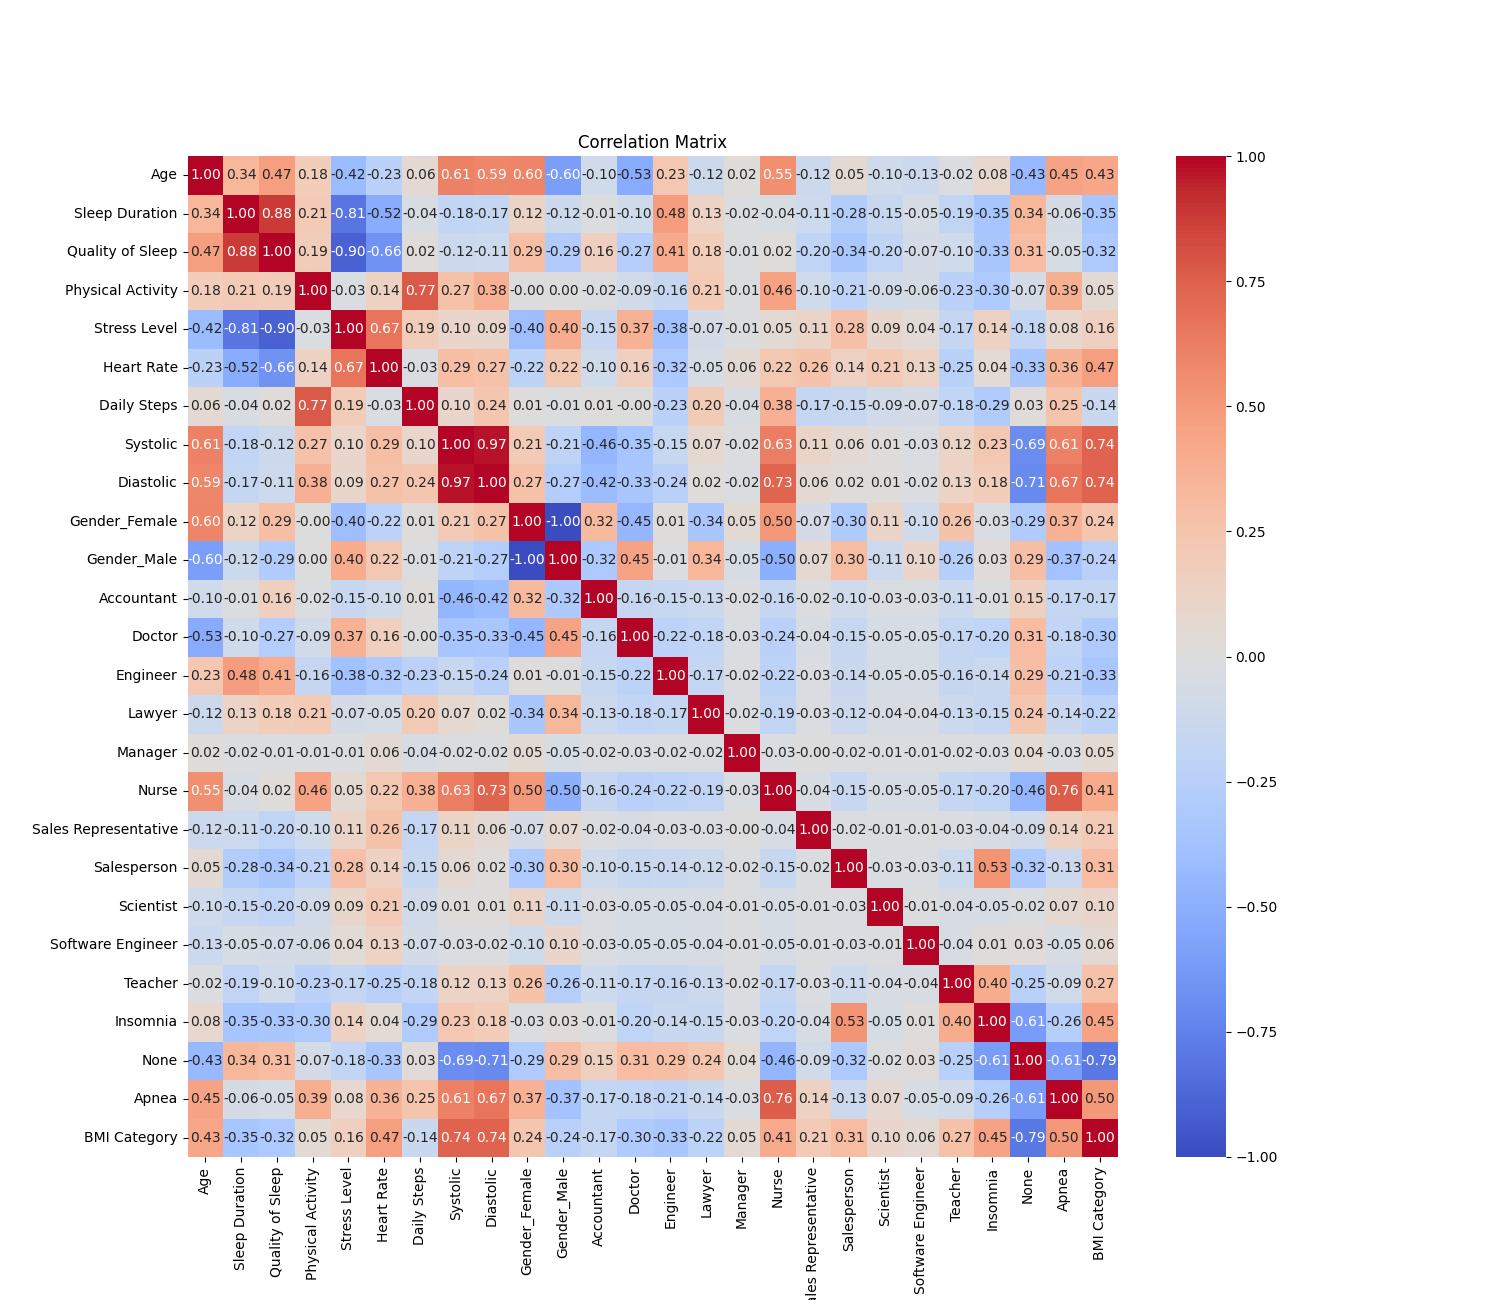

In [110]:
# Encode categorical variables
dummies_gender = pd.get_dummies(data['Gender'], prefix='Gender')
dummies_occupation = pd.get_dummies(data['Occupation'], prefix='Occupation')
dummies_sleep_disorder = pd.get_dummies(data['Sleep Disorder'], prefix='SleepDisorder')

# Convert BMI Category to numeric while handling categorical dtype
with pd.option_context("future.no_silent_downcasting", True):
    data['BMI Category'] = data['BMI Category'].astype(str)
    numeric_bmi_category = data['BMI Category'].replace({'Normal': 0, 'Overweight': 1, 'Obese': 2}).astype(int)

# Combine numerical and encoded categorical data
data_with_dummies = pd.concat(
    [
        data[['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']],
        dummies_gender, dummies_occupation, dummies_sleep_disorder, numeric_bmi_category
    ], axis=1
)
data_with_dummies = data_with_dummies.rename(columns={'Physical Activity Level': 'Physical Activity', 
                                  'Occupation_Accountant': 'Accountant', 'Occupation_Doctor': 'Doctor', 'Occupation_Engineer': 'Engineer',  
                                  'Occupation_Lawyer': 'Lawyer', 'Occupation_Manager': 'Manager', 'Occupation_Nurse': 'Nurse', 
                                  'Occupation_Sales Representative': 'Sales Representative', 'Occupation_Salesperson':'Salesperson', 
                                  'Occupation_Scientist': 'Scientist', 'Occupation_Software Engineer': 'Software Engineer', 
                                  'Occupation_Teacher': 'Teacher', 'SleepDisorder_Insomnia': 'Insomnia', 
                                  'SleepDisorder_Sleep Apnea': 'Apnea', 'SleepDisorder_None': 'None'}, errors="raise")

# Compute and plot correlation matrix
corr_matrix = data_with_dummies.corr().round(2)
plt.figure(figsize=(15, 13))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


The most significant influence on sleep quality is stress level and heart rate. A reduction in stress levels or heart rate is associated with an improvement in sleep quality. In the case of regression, a correlation below 60% is optimal, whereas in the case of clustering or PCA, a high correlation is advantageous. Among all occupations, engineers are observed to have the best quality of sleep, while salespersons and doctors are found to have the poorest. As previously stated, a value of "None" indicates that the individual does not have a sleep disorder. This variable has a strong negative correlation with blood pressure variables and BMI category. This suggests that individuals with the lowest blood pressure and those with a lower BMI are more likely to not have a sleep disorder.

# PCA

In [111]:
pca_data = data_with_dummies
pca_data.drop('Quality of Sleep', axis=1)
variables = pca_data.columns
pca_data = StandardScaler().fit_transform(pca_data)
pca_data = pd.DataFrame(pca_data, columns=variables)
pca_data.columns
pca = PCA(n_components=26)
output_pca = pca.fit_transform(pca_data)

In [112]:
percent_of_explain = (1-pca.explained_variance_ratio_).round(4)
percent_of_explain = pd.concat([
    pd.Series(np.arange(1, 14, 1)).astype(int), pd.Series(percent_of_explain[0:13]),
    pd.Series(np.arange(14, 27, 1)).astype(int), pd.Series(percent_of_explain[13:26])
], axis=1)
percent_of_explain.columns = ['n. components', 'explained variance', 'n. components', 'explained variance']

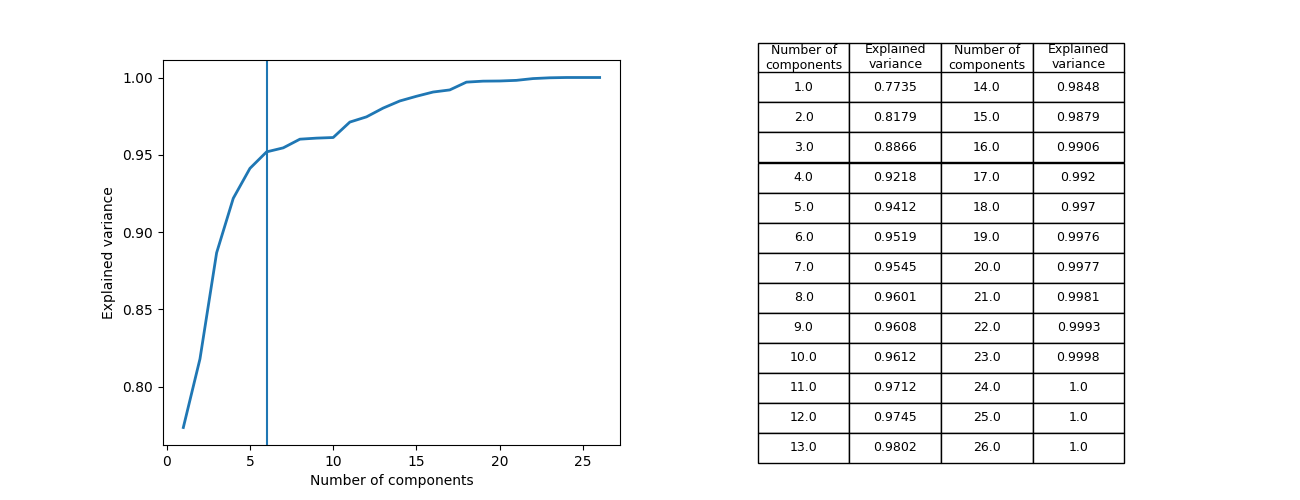

In [113]:
fig, axes = plt.subplots(1, 2, figsize = (13, 5))

percent_of_explain = (1-pca.explained_variance_ratio_)

axes[0].plot(
    np.arange(1, pca.n_components_ + 1), percent_of_explain, 
    linewidth=2, 
)
axes[0].set_ylabel('Explained variance')
axes[0].set_xlabel('Number of components')
axes[0].axvline(6)


percent_of_explain = pd.concat([
    pd.Series(np.arange(1, 14, 1)), pd.Series(percent_of_explain[0:13]),
    pd.Series(np.arange(14, 27, 1)), pd.Series(percent_of_explain[13:26])
], axis=1)

axes[1].axis('off')

table = axes[1].table(
    cellText=percent_of_explain.values.round(4),
    colLabels=['Number of\ncomponents', 'Explained\nvariance', 'Number of\ncomponents', 'Explained\nvariance'],
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(0.8, 1.8)

plt.show()

This figure demonstrates the amount of information contained within the initial *x* principal components. On the left of the line, which corresponds to *x = 6*, the proportion of variance explained by the principal components increases rapidly, attaining 95% of explained variance. In contrast, on the right, this growth slows down, with 15 components explaining 99% of the variance in the 'Quality of Sleep' variable. It is also important to consider the information stored in the first two and three components, as these can be presented on a graph.The results in the table, shows that 82% of the variance is explained by two principal components and 89% by three.The plots will be presented and analysed later.

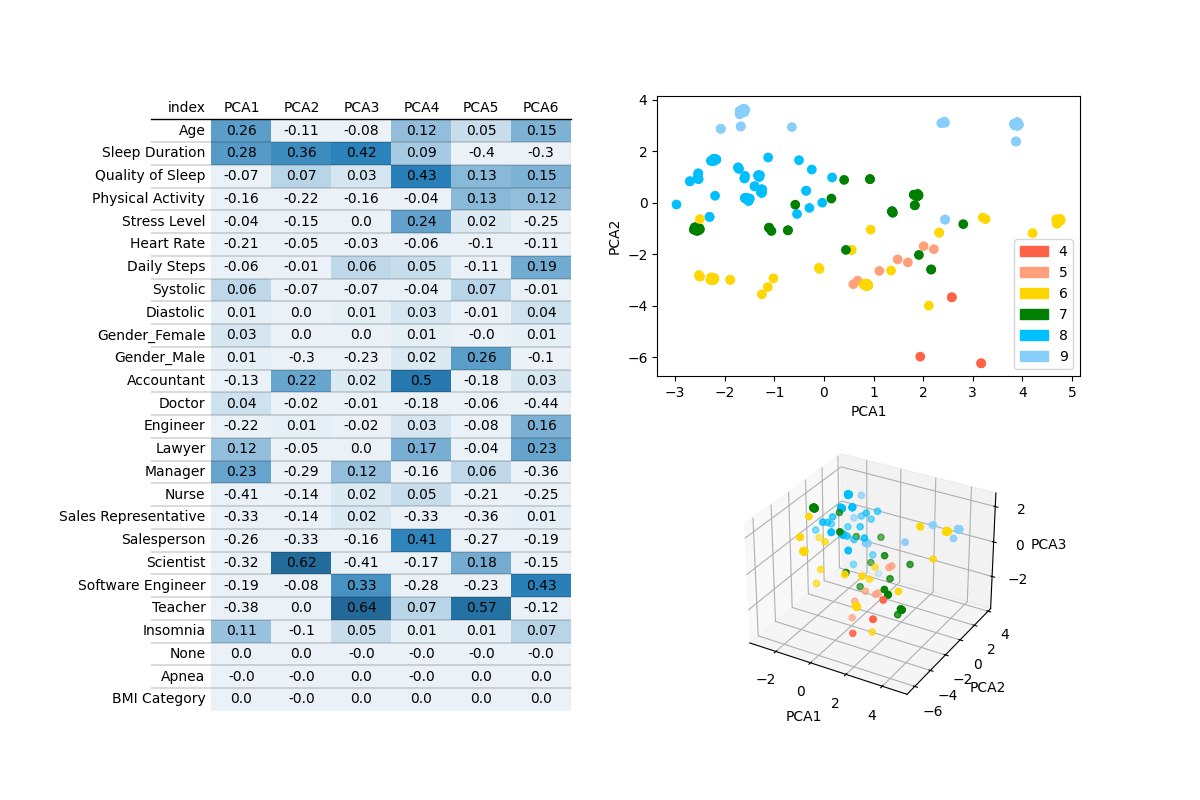

In [114]:
componets_pca = pd.DataFrame(pca.components_[:, 0:6].round(2), columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6'], index=pca_data.columns)
pca_col = list(componets_pca.columns)

fig = plt.figure(figsize = (12, 8))
grid = fig.add_gridspec(nrows=2, ncols=2)
ax1 = fig.add_subplot(grid[:, 0])
ax2 = fig.add_subplot(grid[0, 1])
# ax3 = fig.add_subplot(grid[1, 1])

custom_colors = [
    '#eaf2f8',
    '#7fb3d5',
    '#5499c7',
    '#2980b9',
    '#2471a3',
    '#1f618d',
    '#1a5276',
    '#154360' 
]

# Create a ListedColormap
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", custom_colors)

col_def = (
    [
        ColumnDefinition(
            name=col,
            cmap=custom_cmap,
            textprops={"ha": "center"}
        )
        for col in pca_col
    ]
)

table_comp_pca = Table(componets_pca, column_definitions=col_def, ax=ax1)

# 2D plot

d = {
    'Quality of Sleep': data_with_dummies['Quality of Sleep'].astype("category"),
    'PCA1': output_pca[:, 0], 
    'PCA2': output_pca[:, 1],
    'PCA3': output_pca[:, 2]
}
pca_with_quality_of_sleep = pd.DataFrame(data=d)
colors = {4: 'tomato', 5: 'lightsalmon', 6: 'gold', 7: 'green', 8: 'deepskyblue', 9: 'lightskyblue'}
color_list = [colors[group] for group in pca_with_quality_of_sleep['Quality of Sleep']]

ax2.scatter(pca_with_quality_of_sleep['PCA1'], pca_with_quality_of_sleep['PCA2'], c=color_list)
ax2.set_xlabel('PCA1')
ax2.set_ylabel('PCA2')

legend_handles = [
    mpatches.Patch(color=colors[4], label='4'),
    mpatches.Patch(color=colors[5], label='5'),
    mpatches.Patch(color=colors[6], label='6'),
    mpatches.Patch(color=colors[7], label='7'),
    mpatches.Patch(color=colors[8], label='8'),
    mpatches.Patch(color=colors[9], label='9'),

]
ax2.legend(handles=legend_handles,
          loc='lower right')

%matplotlib widget
ax3 = fig.add_subplot(grid[1, 1], projection='3d')
ax3.scatter(
    pca_with_quality_of_sleep['PCA1'], 
    pca_with_quality_of_sleep['PCA2'], 
    pca_with_quality_of_sleep['PCA3'], 
    c=color_list)

ax3.set_xlabel('PCA1')
ax3.set_ylabel('PCA2')
ax3.set_zlabel('PCA3')

plt.show()

The first component is influenced primarily by variables: *Sleep Duration*, *Age*, and *Manager*. The second component exhibits a significant impact from the variables *Scientist* and *Accountant*, in addition to *Sleep Duration*. The third component is also influenced by *Sleep Duration*, along with the variables *Teacher* and *Software Engineer*. The last three variables displayed in the table, which are: *'None'* (indicating the absence of sleep disorders), *'Sleep Apnea'*, and *'BMI Category'*, do not have any influence on the first six components.The 2D graph illustrates that the quality of sleep is distributed horizontally, with higher values on the PCA2 (y-axis) indicating better sleep quality.As observed in the analysis of the table, the most significant influences on PCA2 are the variables indicating whether an person is a scientist or an accountant, and their sleep duration. The weights are positive, thus if an person is a scientist or an accountant, the probability of that individual achieving a higher quality of sleep is increased. Similarly, if an individual sleeps longer, the probability of achieving a higher quality of sleep is increased.

# Multiple Linear Regression

In order to begin, I will employ a fundamental statistical technique, namely linear regression. A comparison will be made between the results obtained for models created using the complete data set and those derived from the principal component analysis (PCA) data set.

## Model using PCA features

In [12]:
pd.DataFrame(output_pca).describe().round(2)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
count,374.00,374.00,374.00,374.00,374.00,374.00,374.00,374.00,374.00,374.00,...,374.00,374.00,374.00,374.00,374.00,374.00,374.00,374.0,374.0,374.0
mean,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.0,-0.0,0.0
std,2.43,2.18,1.72,1.43,1.24,1.12,1.09,1.02,1.01,1.01,...,0.46,0.28,0.25,0.24,0.22,0.13,0.07,0.0,0.0,0.0
min,-2.97,-6.24,-3.49,-2.40,-7.63,-2.15,-1.62,-6.48,-5.88,-3.88,...,-2.11,-0.73,-1.29,-1.07,-1.20,-0.63,-0.35,-0.0,-0.0,-0.0
25%,-2.18,-1.06,-1.70,-1.31,-0.73,-0.50,-0.55,-0.36,-0.16,-0.08,...,-0.26,-0.15,-0.10,-0.09,-0.05,-0.04,-0.02,-0.0,-0.0,-0.0
50%,-1.27,0.16,0.14,-0.27,0.13,-0.16,-0.33,0.00,-0.03,0.05,...,-0.03,0.04,0.02,0.01,0.01,0.00,-0.00,0.0,-0.0,-0.0
75%,1.87,1.63,1.60,1.16,1.01,0.59,1.08,0.31,0.05,0.11,...,0.21,0.09,0.13,0.11,0.05,0.04,0.02,0.0,0.0,0.0
max,4.77,3.66,2.33,4.07,2.07,2.59,5.61,7.30,8.11,16.89,...,1.55,1.48,1.14,0.69,0.84,0.57,0.42,0.0,0.0,0.0


Because components have similar values I will not standaradize it.

In [115]:
X_pca = pd.DataFrame(output_pca[:, 0:5], columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'])
y_pca = list(data['Quality of Sleep'])

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.3, stratify=y_pca)
terms_pca = X_pca.columns
X_train_pca = MS(terms_pca).fit_transform(X_train_pca)
model_pca = sm.OLS(y_train_pca, X_train_pca)
results_pca = model_pca.fit()
summarize(results_pca)

,coef,std err,t,P>|t|
intercept,7.3035,0.020,358.496,0.000
PCA1,-0.0955,0.009,-11.149,0.000
PCA2,0.4971,0.009,53.394,0.000
PCA3,0.0338,0.012,2.873,0.004
PCA4,-0.1849,0.015,-12.739,0.000
PCA5,0.0198,0.017,1.161,0.247


Last component is not relevant therefore I remove it from dataset. Belove there is final model.

In [116]:
X_pca = pd.DataFrame(output_pca[:, 0:4], columns=['PCA1', 'PCA2', 'PCA3', 'PCA4'])
y_pca = list(data['Quality of Sleep'])

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.3, stratify=y_pca)
terms_pca = X_pca.columns
X_train_pca = MS(terms_pca).fit_transform(X_train_pca)
X_test_pca = MS(terms_pca).fit_transform(X_test_pca)
model_pca = sm.OLS(y_train_pca, X_train_pca)
results_pca = model_pca.fit()
summarize(results_pca)

,coef,std err,t,P>|t|
intercept,7.3266,0.022,335.690,0.000
PCA1,-0.0947,0.009,-10.470,0.000
PCA2,0.4972,0.010,49.611,0.000
PCA3,0.0353,0.013,2.726,0.007
PCA4,-0.1971,0.015,-12.731,0.000


## Model base on dataset variables

In [125]:
X = data[['Age', 'Sleep Duration', 'Heart Rate', 'Daily Steps', 'Diastolic']]
y = data['Quality of Sleep']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=21)

In [128]:
terms = ['Age', 'Sleep Duration', 'Heart Rate', 'Daily Steps', 'Diastolic']
X_train_lin_reg = MS(terms).fit_transform(X_train)
model = sm.OLS(y_train, X_train_lin_reg)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,6.155800,0.834000,7.380,0.000
Age,0.034200,0.005000,7.234,0.000
Sleep Duration,0.946000,0.044000,21.488,0.000
Heart Rate,-0.081000,0.009000,-9.288,0.000
Daily Steps,0.000047,0.000017,2.744,0.007
Diastolic,-0.019800,0.007000,-2.953,0.003


The coefficient of the Daily Steps variable is 0.000047, therefore, this variable will be removed from the model.

In [129]:
terms2 = ['Age', 'Sleep Duration', 'Heart Rate', 'Diastolic']
X_train_lin_reg2 = MS(terms2).fit_transform(X_train)
model = sm.OLS(y_train, X_train_lin_reg2)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,6.1651,0.845,7.299,0.000
Age,0.0323,0.005,6.810,0.000
Sleep Duration,0.9533,0.045,21.421,0.000
Heart Rate,-0.0824,0.009,-9.349,0.000
Diastolic,-0.0145,0.006,-2.234,0.026


The model above could be considered a final model, however, this would only be the case if categorical variables were to be ignored. Otherwise, the search for the most appropriate set of features for multinomial regression will continue.

In [130]:
all_data = list(data.columns.drop(['Quality of Sleep', 'Blood Pressure', 'Occupation']))
data[['Gender', 'BMI Category', 'Sleep Disorder']] = data[['Gender', 'BMI Category', 'Sleep Disorder']].astype("category")

# Second data split - with also categorical features
X_train_all, X_test_all, y_train, y_test = train_test_split(data[all_data], y, test_size=0.3, stratify=y, random_state=21)

# Model with all data 
X_train_all = MS(all_data).fit_transform(X_train_all)
X_test_all =  MS(all_data).fit_transform(X_test_all)
model_all = sm.OLS(y_train, X_train_all)
results_all = model_all.fit()
summarize(results_all)
#results_all.ssr
    

,coef,std err,t,P>|t|
intercept,8.352300,1.121000,7.448,0.000
Gender[Male],0.392400,0.070000,5.630,0.000
Age,0.064900,0.006000,11.191,0.000
Sleep Duration,0.049500,0.064000,0.771,0.441
Physical Activity Level,0.000500,0.002000,0.212,0.833
Stress Level,-0.446200,0.035000,-12.832,0.000
BMI Category[Obese],-0.425600,0.222000,-1.915,0.057
BMI Category[Overweight],-0.684900,0.094000,-7.309,0.000
Heart Rate,-0.003800,0.013000,-0.293,0.770
Daily Steps,0.000048,0.000028,1.691,0.092


A number of variables have a p-value greater than 0.05, indicating that they are not statistically significant. However, in some cases, this may be due to a high correlation between variables. This phenomenon can be observed in the data set with respect to the relationship *Daily Steps* with *Physical Activity Level*, *Sleep Duration* and *Stress Level* with *Heart Rate* and *Systolic* with *Diastolic*. Therefore I add 5 variables: Daily Steps\*Physical Activity Level, Stress Level\*Sleep Duration, Heart Rate\*Sleep Duration, Heart Rate\*Stress Level, Diastolic\*Systolic.

In [131]:
columns_and_relationships = list(X_train_all.columns)
columns_and_relationships.remove('intercept')
columns_and_relationships = columns_and_relationships + [('Stress Level', 'Sleep Duration'), ('Heart Rate', 'Sleep Duration'),
                                                        ('Heart Rate', 'Stress Level'), ('Daily Steps', 'Physical Activity Level'),
                                                        ('Diastolic', 'Systolic')]

In [132]:
X_train_with_interaction = MS(columns_and_relationships).fit_transform(X_train_all)
model_all = sm.OLS(y_train, X_train_with_interaction)
results_all = model_all.fit()
summarize(results_all)

,coef,std err,t,P>|t|
intercept,-28.720200,1.080600e+01,-2.658,0.008
Gender[Male],-0.259700,7.500000e-02,-3.442,0.001
Age,0.032400,6.000000e-03,5.666,0.000
Sleep Duration,5.283800,9.420000e-01,5.610,0.000
Physical Activity Level,0.054000,7.000000e-03,7.265,0.000
Stress Level,3.407900,4.890000e-01,6.964,0.000
BMI Category[Obese],-0.038600,2.010000e-01,-0.193,0.847
BMI Category[Overweight],-0.534100,7.500000e-02,-7.080,0.000
Heart Rate,0.674500,1.280000e-01,5.286,0.000
Daily Steps,0.000500,5.000000e-05,9.012,0.000


Stress Level\*Sleep Duration has high p-value, thus resulting in its removal from the dataset. A similar decision was made with respect to the variable *BMI Category[Obese]*.

In [133]:
columns_and_relationships.remove(('Stress Level', 'Sleep Duration'))
columns_and_relationships.remove('BMI Category[Obese]')

### Model 1 - with relationships

In [134]:
X_train_with_interaction = MS(columns_and_relationships).fit_transform(X_train_all)
X_test_with_interaction = MS(columns_and_relationships).fit_transform(X_test_all)
model_all = sm.OLS(y_train, X_train_with_interaction)
results_all = model_all.fit()
summarize(results_all)

,coef,std err,t,P>|t|
intercept,-30.146100,9.545000e+00,-3.158,0.002
Gender[Male],-0.243700,6.400000e-02,-3.783,0.000
Age,0.036100,5.000000e-03,7.262,0.000
Sleep Duration,5.670800,8.860000e-01,6.399,0.000
Physical Activity Level,0.052200,7.000000e-03,7.444,0.000
Stress Level,3.362600,4.640000e-01,7.250,0.000
BMI Category[Overweight],-0.563400,6.800000e-02,-8.274,0.000
Heart Rate,0.741600,1.180000e-01,6.286,0.000
Daily Steps,0.000400,4.840000e-05,9.049,0.000
Sleep Disorder[None],0.252900,5.100000e-02,4.995,0.000


The model presented above is the definitive model. All characteristics have a p-value below 0.05.

I would like to see how look correlation between every variables and Quality of Sleep. Plots are printed below. 

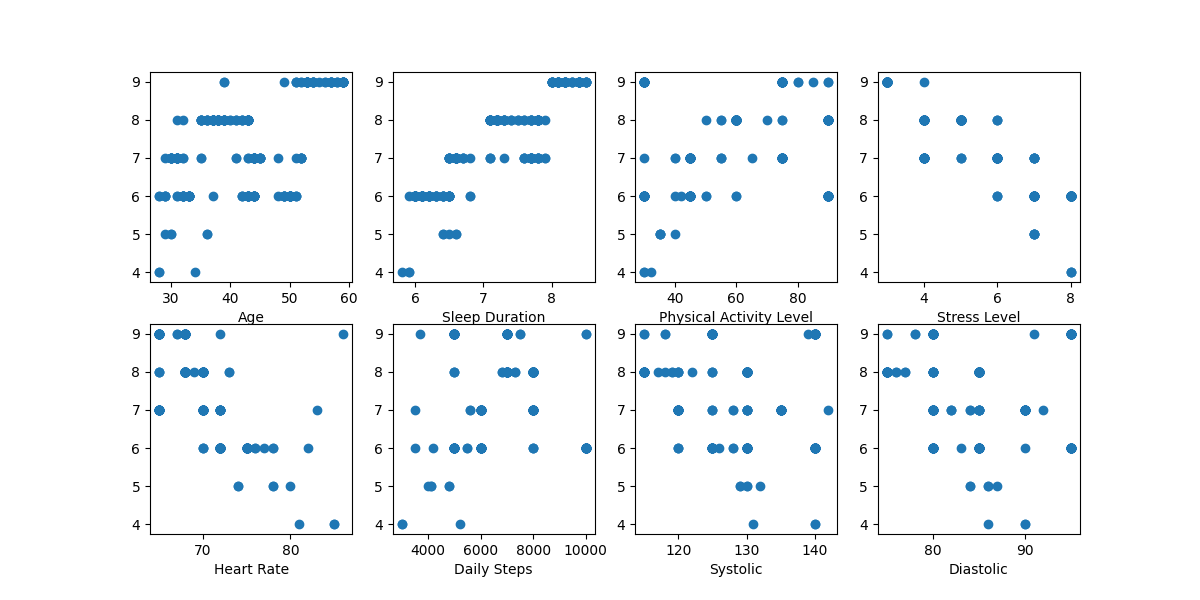

In [135]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize=(12, 6))
variables = ['Age', 'Sleep Duration', 'Physical Activity Level','Stress Level', 'Heart Rate', 'Daily Steps',
       'Systolic', 'Diastolic']

for (i, var), ax in zip(enumerate(variables), axes.ravel()):
    ax.scatter(X_train_with_interaction[var], y_train)
    ax.set_xlabel(var)


Looking at the plots above it is not that between all variables have linear correlation with quality of sleep. Therefore I look also at the model with squared variables.

In [136]:
X_train_all['Age_2'] = pow(X_train_all['Age'], 2)
X_train_all['Sleep Duration_2'] = pow(X_train_all['Sleep Duration'], 2)
X_train_all['Physical Activity Level_2'] = pow(X_train_all['Physical Activity Level'], 2)
X_train_all['Heart Rate_2'] = pow(X_train_all['Heart Rate'], 2)
X_train_all['Daily Steps_2'] = pow(X_train_all['Daily Steps'], 2)
X_train_all['Systolic_2'] = pow(X_train_all['Systolic'], 2)
X_train_all['Diastolic_2'] = pow(X_train_all['Diastolic'], 2)

In [137]:
X_test_all['Age_2'] = pow(X_test_all['Age'], 2)
X_test_all['Sleep Duration_2'] = pow(X_test_all['Sleep Duration'], 2)
X_test_all['Physical Activity Level_2'] = pow(X_test_all['Physical Activity Level'], 2)
X_test_all['Heart Rate_2'] = pow(X_test_all['Heart Rate'], 2)
X_test_all['Daily Steps_2'] = pow(X_test_all['Daily Steps'], 2)
X_test_all['Systolic_2'] = pow(X_test_all['Systolic'], 2)
X_test_all['Diastolic_2'] = pow(X_test_all['Diastolic'], 2)

In [138]:
columns_and_relationships_2 = list()
columns_and_relationships_2 = list(columns_and_relationships)
columns_and_relationships_2 = columns_and_relationships_2 + ['Age_2', 'Sleep Duration_2', 'Physical Activity Level_2', 'Heart Rate_2', 'Systolic_2', 'Diastolic_2']

In [139]:
X_train_2 = MS(columns_and_relationships_2).fit_transform(X_train_all)
model_2 = sm.OLS(y_train, X_train_2)
results_2 = model_2.fit()
summarize(results_2)

,coef,std err,t,P>|t|
intercept,-90.062900,1.059200e+01,-8.503,0.000
Gender[Male],-0.411900,5.800000e-02,-7.042,0.000
Age,0.101800,2.100000e-02,4.857,0.000
Sleep Duration,10.954100,1.454000e+00,7.533,0.000
Physical Activity Level,0.030100,9.000000e-03,3.497,0.001
Stress Level,3.786800,4.260000e-01,8.884,0.000
BMI Category[Overweight],-0.414100,6.300000e-02,-6.621,0.000
Heart Rate,1.475400,1.340000e-01,11.037,0.000
Daily Steps,0.000600,6.000000e-05,9.639,0.000
Sleep Disorder[None],0.136900,4.400000e-02,3.099,0.002


All squared variables are significant at level of 0.05, but one of the latest variables *(Sleep Disorder[Sleep Apnea])* seem to be unimportant and as a result it will be removed.

In [140]:
columns_and_relationships_2_1 = list(columns_and_relationships_2)
columns_and_relationships_2_1.remove('Sleep Disorder[Sleep Apnea]')

### Model 2 - with squared variables

In [141]:
X_train_2_1 = MS(columns_and_relationships_2_1).fit_transform(X_train_all)
X_test_2_1 = MS(columns_and_relationships_2_1).fit_transform(X_test_all)
model_2_1 = sm.OLS(y_train, X_train_2_1)
results_2_1 = model_2_1.fit()
summarize(results_2_1)

,coef,std err,t,P>|t|
intercept,-93.260000,1.052300e+01,-8.863,0.000
Gender[Male],-0.397600,5.800000e-02,-6.815,0.000
Age,0.109300,2.100000e-02,5.276,0.000
Sleep Duration,11.305900,1.451000e+00,7.791,0.000
Physical Activity Level,0.029500,9.000000e-03,3.405,0.001
Stress Level,3.738800,4.280000e-01,8.736,0.000
BMI Category[Overweight],-0.423300,6.300000e-02,-6.748,0.000
Heart Rate,1.478900,1.340000e-01,11.001,0.000
Daily Steps,0.000600,5.910000e-05,10.185,0.000
Sleep Disorder[None],0.105500,4.100000e-02,2.554,0.011


The model above represents the second model, which, in contrast to the first, takes into account the non-linear correlation between variables. \
In the third and final model, the VIF (variance inflation factor) is also examined. This factor is used to identify the correlation between two, three, or more variables that is not apparent in the correlation matrix. This issue is named multicollinearity. The minimum value of vif is 1 and that's mean there is no collinearity. Acceptable value is less than 5-10.

In [145]:
col = list(X_train_all.columns)
idx_col = [1, 5, 6, 7, 10, 11, 14]
col = [col[i] for i in idx_col]
X_vif = pd.DataFrame(X_train_all.iloc[:, idx_col], columns=col)
vals = [VIF(X_vif, i) for i in range(0, X_vif.shape[1])]
vif = pd.DataFrame({'vif':vals}, index=X_vif.columns[0:])
vif.round()

,vif
Gender[Male],3.0
Stress Level,9.0
BMI Category[Obese],1.0
BMI Category[Overweight],6.0
Sleep Disorder[None],6.0
Sleep Disorder[Sleep Apnea],2.0
Age_2,8.0


Although there are values above 10 I leave all of the above variables to create the model, as these variables affect the model results.

### Model 3 - after vif

In [146]:
X_train_s = MS(col).fit_transform(X_train_all)
X_test_s = MS(col).fit_transform(X_test_all)
model_s = sm.OLS(y_train, X_train_s)
results_s = model_s.fit()
summarize(results_s)

,coef,std err,t,P>|t|
intercept,8.4787,0.149000,56.849,0.0
Gender[Male],0.3728,0.049000,7.551,0.0
Stress Level,-0.4740,0.015000,-32.323,0.0
BMI Category[Obese],-0.9878,0.151000,-6.562,0.0
BMI Category[Overweight],-0.7019,0.069000,-10.149,0.0
Sleep Disorder[None],0.3537,0.070000,5.038,0.0
Sleep Disorder[Sleep Apnea],0.2930,0.064000,4.564,0.0
Age_2,0.0007,0.000041,16.325,0.0


## Comparison of Multiple Linear Regression Models

In [147]:
test_n = len(y_test)

In [192]:
predictions_1 = results_all.get_prediction(X_test_with_interaction)
predictions_2 = results_2_1.get_prediction(X_test_2_1)
predictions_3 = results_s.get_prediction(X_test_s)
prediction_pca = results_pca.get_prediction(X_test_pca)

test_sse1 = pow(y_test - predictions_1.predicted, 2).sum()
test_sse2 = pow(y_test - predictions_2.predicted, 2).sum()
test_sse3 = pow(y_test - predictions_3.predicted, 2).sum()
test_sse_pca = pow(y_test_pca - prediction_pca.predicted, 2).sum()

y_test_mean = sum(y_test)/test_n
y_test_mean_pca = sum(y_test_pca)/len(y_test_pca)
test_ss_total = pow(y_test - y_test_mean, 2).sum()
test_ss_total_pca = pow(np.array(y_test_pca) - y_test_mean_pca, 2).sum()

test_r2_1 = 1-(test_sse1/test_ss_total)
test_r2_2 = 1-(test_sse2/test_ss_total)
test_r2_3 = 1-(test_sse3/test_ss_total)
test_r2_pca = 1-(test_sse_pca/test_ss_total_pca)

# Accuracy and f1 score of multiple linear regression
accuracy_lin1 = accuracy_score(y_test, predictions_1.predicted.astype(int))
accuracy_lin2 = accuracy_score(y_test, predictions_2.predicted.astype(int))
accuracy_lin3 = accuracy_score(y_test, predictions_3.predicted.astype(int))
accuracy_lin_pca = accuracy_score(y_test_pca, prediction_pca.predicted.astype(int))

f1_lin1 = f1_score(y_test, predictions_1.predicted.astype(int), average='weighted')
f1_lin2 = f1_score(y_test, predictions_2.predicted.astype(int), average='weighted')
f1_lin3 = f1_score(y_test, predictions_3.predicted.astype(int), average='weighted')
f1_lin_pca = f1_score(y_test_pca, prediction_pca.predicted.astype(int), average='weighted')

model_comparison = pd.DataFrame({
    'train_adjusted_r2': [results_all.rsquared_adj, results_2_1.rsquared_adj, results_s.rsquared_adj, results_pca.rsquared_adj],
    'test_adjusted_r2': [test_r2_1, test_r2_2, test_r2_3, test_r2_pca],
    'train_mse' : [results_all.mse_resid, results_2_1.mse_resid, results_s.mse_resid, results_pca.mse_resid],
    'test_mse': [test_sse1/test_n, test_sse2/test_n, test_sse3/test_n, test_sse_pca/len(y_test_pca)],
})

model_comparison.index = ['model 1', 'model 2', 'model 3', 'model PCA']
model_comparison

,train_adjusted_r2,test_adjusted_r2,train_mse,test_mse
model 1,0.972897,0.948075,0.038462,0.075986
model 2,0.982963,0.953706,0.024177,0.067746
model 3,0.937070,0.931035,0.089304,0.100923
model PCA,0.912529,0.941326,0.124129,0.085863


To compare models the adjusted R² value is used, since the number of variables is different in each model and the R² value increases with an increase in the number of variables.
All models achieved good results more than 0.90, that's means they explain more than 90% of variance in the variable *Quality Of Sleep*. Model 1 and 2 achived slightly better results on both training and test sets in comparison to rest models. The best models achive 97-98% on the train set and 95% on test set, what is in my opinion really good result.

# Machine Learning methods
Beside multinomial regression I would like to test different methods to find the best model for classification in this case.

## SVM
 
SVM can be used not only for binary classification, but also for multiclass classification. In sklearn there are two posible ways: one-versus-one and one-versus-rest. I try both methods and compare their outputs and times they take to complete the task.


### One-versus-one

In [177]:
X = data_with_dummies.drop(columns='Quality of Sleep')
y = data_with_dummies['Quality of Sleep']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=21)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [178]:
clf_svm = svm.SVC(decision_function_shape='ovo', random_state=21)
clf_svm.fit(X_train, y_train)

c_params = [1, 5, 25, 50, 100]
gamma_params = [0.001, 0.005, 0.01, 0.05, 0.1]

p_grid = [
    {'C': c_params, 'gamma': gamma_params, 'kernel': ['linear', 'rbf', 'sigmoid']},
    {'C': c_params, 'gamma': gamma_params, 'kernel': ['poly'], 'degree': [2, 3, 4, 5]},
]

gs = GridSearchCV(estimator=clf_svm, param_grid=p_grid, cv=3, return_train_score=True)
gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=SVC(decision_function_shape='ovo', random_state=21),
             param_grid=[{'C': [1, 5, 25, 50, 100],
                          'gamma': [0.001, 0.005, 0.01, 0.05, 0.1],
                          'kernel': ['linear', 'rbf', 'sigmoid']},
                         {'C': [1, 5, 25, 50, 100], 'degree': [2, 3, 4, 5],
                          'gamma': [0.001, 0.005, 0.01, 0.05, 0.1],
                          'kernel': ['poly']}],
             return_train_score=True)

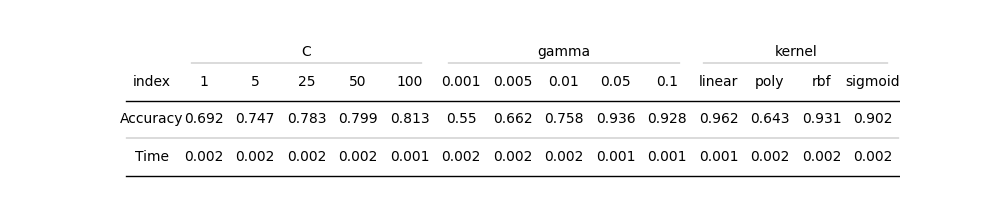

In [179]:
svm_gs_output = pd.concat([
    pd.DataFrame(gs.cv_results_["params"]),
    pd.DataFrame(gs.cv_results_["mean_test_score"], columns=["Accuracy"]), 
    pd.DataFrame(gs.cv_results_['mean_fit_time'], columns=['Time'])
],axis=1)
svm_c = svm_gs_output[['Accuracy', 'Time', 'C']].groupby(['C']).mean()
svm_gamma = svm_gs_output[['Accuracy', 'Time', 'gamma']].groupby(['gamma']).mean()
svm_kernel = svm_gs_output[['Accuracy', 'Time', 'kernel']].groupby(['kernel']).mean()

svm_gs_output_group = pd.concat([svm_c, svm_gamma, svm_kernel], axis=0, keys=['C', 'gamma', 'kernel'])
svm_gs_output_group = pd.DataFrame(svm_gs_output_group.values.T.round(3), 
                                    columns = pd.Series(c_params + gamma_params + ['linear', 'poly', 'rbf', 'sigmoid']), 
                                    index=['Accuracy', 'Time'])

fig, ax = plt.subplots(figsize=(10, 2))

col_def = (
    [
        ColumnDefinition(
            name=col,
            group='C',
            textprops={
                "ha": "center",
            },
        )
        for col in c_params
    ]
    + [
        ColumnDefinition(
            name=col,
            group='gamma',
            textprops={
                "ha": "center",
            },
        )
        for col in gamma_params
    ]
    + [
        ColumnDefinition(
            name=col,
            group='kernel',
            textprops={
                "ha": "center",
            },
        )
        for col in ['linear', 'poly', 'rbf', 'sigmoid']
    ]
)

tab = Table(svm_gs_output_group, textprops={'ha': 'center'},
            footer_divider=True,
            column_definitions=col_def,
    )

The biggest difference between accurancy is in gamma parameters. Small values have accurancy arround 0.6-0.7. In comparison the highest accurancy for 0.05 is euqal 0.94. Similar situation is in case of C parametr, because for higher value there is better accurancy. In contrast, in the case of the kerenl, different parameters have quite similar results, but polynomial kernel have definitely the worst results, even changing the degree does not help *(the exact results for the different degree are shown in the table below)*.

In [180]:
svm_gs_output[['Accuracy', 'degree']].groupby(['degree']).mean().T

degree,2.0,3.0,4.0,5.0
Accuracy,0.741303,0.678161,0.595862,0.557854


In [181]:
svm_best1 = svm.SVC(decision_function_shape='ovo', C=100, gamma=0.05, kernel='linear')
svm_best1.fit(X_train, y_train)
accurancy_svm1_ovo = svm_best1.score(X_test, y_test)
svm_best1_y = svm_best1.predict(X_test)
f1_svm1_ovo = f1_score(y_test, svm_best1_y, average='weighted')

svm_best2 = svm.SVC(decision_function_shape='ovo', C=50, gamma=0.01, kernel='sigmoid')
svm_best2.fit(X_train, y_train)
accurancy_svm2_ovo = svm_best2.score(X_test, y_test)
svm_best2_y = svm_best2.predict(X_test)
f1_svm2_ovo = f1_score(y_test, svm_best2_y, average='weighted')

pd.DataFrame({
    'model 1': [accurancy_svm1_ovo, f1_svm1_ovo],
    'model 2': [accurancy_svm2_ovo, f1_svm2_ovo],
}, index=['accurancy', 'f1 score'])

,model 1,model 2
accurancy,0.955752,0.955752
f1 score,0.955428,0.957751


Looking at the output of GridSearchCV function the best model have parameters: C=50, gamma=0.01, kernel='sigmoid'. But looking at the tables we can supposed that the best model have parameters: C=100, gamma=0.05, kernel='linear'. After training and testing algorith on both set of parameters it occure that they have the same test accurancy, second model (whose parameters are based on the tables) have better f1-score, but only by about 0.1 per cent. Therefore both models give similar result.

### One-versus-rest

In [182]:
clf_svm2 = svm.SVC(decision_function_shape='ovr', random_state=21)
clf_svm2.fit(X_train, y_train)

p_grid = [
    {'C': c_params, 'gamma': gamma_params, 'kernel': ['linear', 'rbf', 'sigmoid']},
    {'C': c_params, 'gamma': gamma_params, 'kernel': ['poly'], 'degree': [2, 3, 4, 5]},
]

gs = GridSearchCV(estimator=clf_svm2, param_grid=p_grid, cv=3)
gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(random_state=21),
             param_grid=[{'C': [1, 5, 25, 50, 100],
                          'gamma': [0.001, 0.005, 0.01, 0.05, 0.1],
                          'kernel': ['linear', 'rbf', 'sigmoid']},
                         {'C': [1, 5, 25, 50, 100], 'degree': [2, 3, 4, 5],
                          'gamma': [0.001, 0.005, 0.01, 0.05, 0.1],
                          'kernel': ['poly']}])

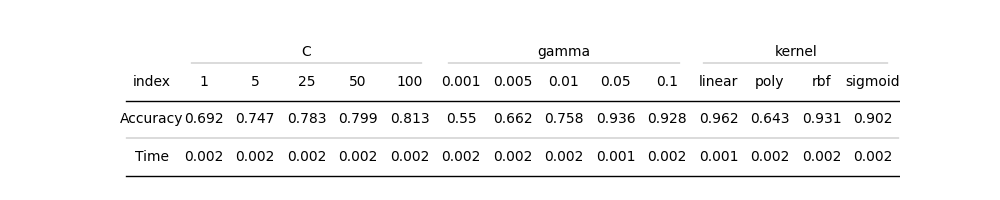

In [183]:
svm_gs_output2 = pd.concat([
    pd.DataFrame(gs.cv_results_["params"]),
    pd.DataFrame(gs.cv_results_["mean_test_score"], columns=["Accuracy"]), 
    pd.DataFrame(gs.cv_results_['mean_fit_time'], columns=['Time'])
],axis=1)
svm_c2 = svm_gs_output2[['Accuracy', 'Time', 'C']].groupby(['C']).mean()
svm_gamma2 = svm_gs_output2[['Accuracy', 'Time', 'gamma']].groupby(['gamma']).mean()
svm_kernel2 = svm_gs_output2[['Accuracy', 'Time', 'kernel']].groupby(['kernel']).mean()

svm_gs_output_group2 = pd.concat([svm_c2, svm_gamma2, svm_kernel2], axis=0, keys=['C', 'gamma', 'kernel'])
svm_gs_output_group2 = pd.DataFrame(svm_gs_output_group2.values.T.round(3), 
                                    columns = pd.Series(c_params + gamma_params + ['linear', 'poly', 'rbf', 'sigmoid']), 
                                    index=['Accuracy', 'Time'])

fig, ax = plt.subplots(figsize=(10, 2))

col_def = (
    [
        ColumnDefinition(
            name=col,
            group='C',
            textprops={
                "ha": "center",
            },
        )
        for col in c_params
    ]
    + [
        ColumnDefinition(
            name=col,
            group='gamma',
            textprops={
                "ha": "center",
            },
        )
        for col in gamma_params
    ]
    + [
        ColumnDefinition(
            name=col,
            group='kernel',
            textprops={
                "ha": "center",
            },
        )
        for col in ['linear', 'poly', 'rbf', 'sigmoid']
    ]
)

tab = Table(svm_gs_output_group2, textprops={'ha': 'center'},
            footer_divider=True, 
            column_definitions=col_def,
    )

In [184]:
svm_gs_output2[['Accuracy', 'degree']].groupby(['degree']).mean().T

degree,2.0,3.0,4.0,5.0
Accuracy,0.741303,0.678161,0.595862,0.557854


The conclusions drawn in this study bear a strong resemblance to those previously outlined in the extant literature. For the C and gamma parameters, it was demonstrated that an increase in value resulted in a corresponding improvement in outcome. Also, the polynomial model obtained the worst results in terms of the kernel parameter. I supposed bigger difference in time between one-vs-one and one-vs-rest models, but probably dataset is too small to see the difference.In summary, the SVM models attained an accuracy and an f1 score of 96%.

In [185]:
svm_best1 = svm.SVC(decision_function_shape='ovr', C=100, gamma=0.05, kernel='linear')
svm_best1.fit(X_train, y_train)
accurancy_svm1_ovr = svm_best1.score(X_test, y_test)
svm_best1_y = svm_best1.predict(X_test)
f1_svm1_ovr = f1_score(y_test, svm_best1_y, average='weighted')

svm_best2 = svm.SVC(decision_function_shape='ovr', C=50, gamma=0.01, kernel='sigmoid')
svm_best2.fit(X_train, y_train)
accurancy_svm2_ovr = svm_best2.score(X_test, y_test)
svm_best2_y = svm_best2.predict(X_test)
f1_svm2_ovr = f1_score(y_test, svm_best2_y, average='weighted')

pd.DataFrame({
    'model 1': [accurancy_svm1_ovr, f1_svm1_ovr],
    'model 2': [accurancy_svm2_ovr, f1_svm2_ovr],
}, index=['accurancy', 'f1 score'])

,model 1,model 2
accurancy,0.955752,0.955752
f1 score,0.955428,0.957751


As with the one-vs-one model, the results are very similar. Both Accuracy and F1 Score are around 96%.

## Random forest

In [172]:
rf_clf = RandomForestClassifier(random_state=21)

n_estimators_params = [50, 100, 150, 200]
max_dept_params = [2, 3, 4, 5, 6, 7, 8]
p_grid = {'n_estimators': n_estimators_params, 'max_depth': max_dept_params}

gs = GridSearchCV(estimator=rf_clf, param_grid=p_grid, cv=3)
gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=21),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'n_estimators': [50, 100, 150, 200]})

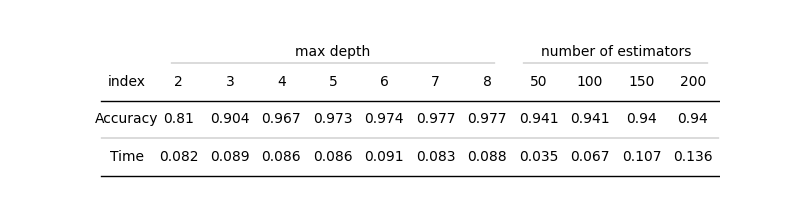

In [173]:
rf_gs_output = pd.concat([
    pd.DataFrame(gs.cv_results_['params']),
    pd.DataFrame(gs.cv_results_['mean_test_score'], columns=['Accuracy']),
    pd.DataFrame(gs.cv_results_['mean_fit_time'], columns=['Time'])
], axis=1)
rf_max_depth = rf_gs_output[['Accuracy', 'Time', 'max_depth']].groupby(['max_depth']).mean()
rf_n_estimators = rf_gs_output[['Accuracy', 'Time', 'n_estimators']].groupby(['n_estimators']).mean()

rf_gs_output_group = pd.concat([rf_max_depth, rf_n_estimators], axis=0, keys=['max_depth', 'n_estimators'])
rf_gs_output_group = pd.DataFrame(rf_gs_output_group.values.T.round(3), columns = [2, 3, 4, 5, 6, 7, 8, 50, 100, 150, 200], index=['Accuracy', 'Time'])

fig, ax = plt.subplots(figsize=(8, 2))

col_def = (
    [
        ColumnDefinition(
            name=col,
            group='max depth',
            textprops={
                "ha": "center",
            },
        )
        for col in max_dept_params
    ]
    + [
        ColumnDefinition(
            name=col,
            group='number of estimators',
            textprops={
                "ha": "center",
            },
        )
        for col in n_estimators_params
    ]
)

tab = Table(rf_gs_output_group, textprops={'ha': 'center'}, # text properties
            footer_divider=True, # add a reference line at the end
            column_definitions=col_def,
    )

The larger trees the model builds, the better results we get. What is more in case of this dataset there is not big difference between time. In contrast for the number of estimators in the range 50-200, there is not much difference in the accuracy, which in average is euqal 0.94, but there is bigger difference in time, because for n_estimators=200 time is almost four times longer.

In [227]:
rf_plot = pd.DataFrame(columns=['max_depth', 'train_accuracy', 'train_f1_score', 'test_accuracy', 'test_f1_score'])
rf_plot['max_depth'] = max_dept_params
for i, depth in enumerate(max_dept_params):
    rf_clf = RandomForestClassifier(max_depth=depth, n_estimators=50, random_state=21)
    rf_clf.fit(X_train, y_train)
    y_predict_rf = rf_clf.predict(X_test)
    y_predict_rf_train = rf_clf.predict(X_train)
    rf_plot.iloc[i, 1] = round(accuracy_score(y_train, y_predict_rf_train), 4)
    rf_plot.iloc[i, 2] = round(f1_score(y_train, y_predict_rf_train, average='weighted'), 4)
    rf_plot.iloc[i, 3] = round(accuracy_score(y_test, y_predict_rf), 4)
    rf_plot.iloc[i, 4] = round(f1_score(y_test, y_predict_rf, average='weighted'), 4)


In [228]:
rf_plot

,max_depth,train_accuracy,train_f1_score,test_accuracy,test_f1_score
0,2,0.8429,0.8137,0.823,0.7851
1,3,0.9617,0.9471,0.9204,0.9035
2,4,0.977,0.9675,0.9292,0.9193
3,5,1.0,1.0,0.9823,0.9823
4,6,1.0,1.0,0.9823,0.9823
5,7,1.0,1.0,0.9823,0.9823
6,8,1.0,1.0,0.9735,0.9735


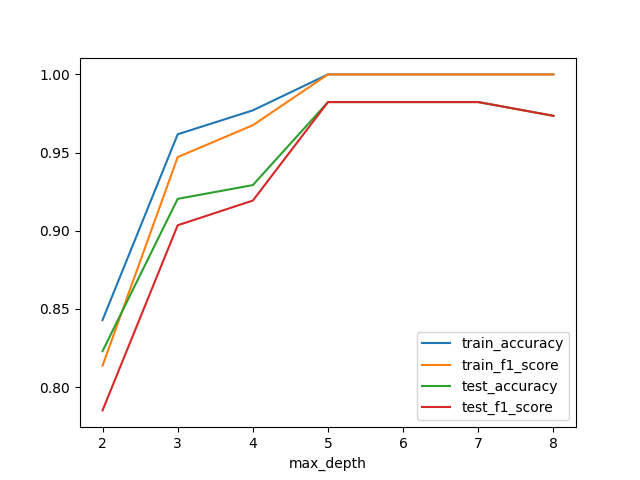

In [223]:
plt.figsize = (8, 6)

rf_plot.plot(x = 'max_depth', kind='line')
plt.legend(loc='lower right')

plt.show()

In [229]:
rf_clf = RandomForestClassifier(max_depth=5, n_estimators=50, random_state=21)
rf_clf.fit(X_train, y_train)
y_predict_rf = rf_clf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_predict_rf)
f1_score_rf = f1_score(y_test, y_predict_rf, average='weighted')

## KNN

In [186]:
neighbor = KNeighborsClassifier(n_jobs=-1)

p_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

gs = GridSearchCV(estimator=neighbor, param_grid=p_grid, cv=3)
gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=-1),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]})

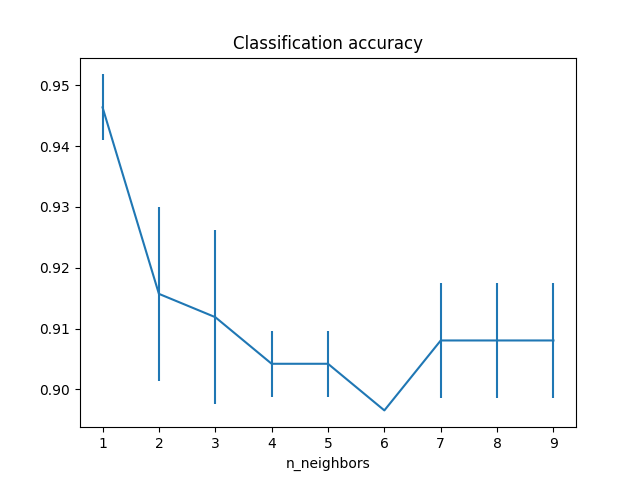

In [187]:
fig, ax = plt.subplots()
plt.errorbar(
    x=[1, 2, 3, 4, 5, 6, 7, 8, 9],
    y=gs.cv_results_["mean_test_score"],
    yerr=gs.cv_results_["std_test_score"],
)
ax.set_xlabel("n_neighbors")
ax.set_title("Classification accuracy")
plt.show()

The best results KNN algorith gives for number of neighbors euqal one. Good result give also model with number of neighbors between 4 and 6, but bigger vale definitely give worst results.

In [188]:
neighbor = KNeighborsClassifier(n_neighbors=1)
neighbor.fit(X_train, y_train)
y_predict_knn = neighbor.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_predict_knn)
f1_knn = f1_score(y_test, y_predict_knn, average= 'weighted')

## Comparison of Machine Learning Models

In [189]:
ml_results = pd.DataFrame({
    'SVM': [accurancy_svm1_ovr, f1_svm1_ovr],
    'Random Forest': [accuracy_rf, f1_score_rf],
    'KNN': [accuracy_knn, f1_knn]
}, index=['accuracy', 'f1 score'])
ml_results

,SVM,Random Forest,KNN
accuracy,0.955752,0.982301,0.946903
f1 score,0.955428,0.982269,0.945897


The best results achive Random Forest algorith with accurancy and f1 score euqal 98%. 

# Summary

In [230]:
lin_results = pd.DataFrame({
    'model 1': [accuracy_lin1, f1_lin1],
    'model 2': [accuracy_lin2, f1_lin2],
    'model 3': [accuracy_lin3, f1_lin3],
    'model pca': [accuracy_lin_pca, f1_lin_pca]
}, index=['accuracy', 'f1 score'])

pd.concat([ml_results, lin_results], axis=1)

,SVM,Random Forest,KNN,model 1,model 2,model 3,model pca
accuracy,0.955752,0.982301,0.946903,0.610619,0.575221,0.504425,0.504425
f1 score,0.955428,0.982269,0.945897,0.637539,0.608110,0.526337,0.529080


The best results are from a machine learning model, particular - Random Forest. It has an accuracy and an F1 score of 98%, which is a very good score.